# Time series analysis for area in Northern Ghana

Creating Sentinel 2 EVI and sentinel 2 smoothed EVI Time series.


## Import and authenticate the Earth Engine Python API

Along with the [`geemap`](https://geemap.org/) library.

In [1]:
import ee
import geemap
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from matplotlib.dates import date2num


In [2]:
ee.Authenticate()

# Initialize the Earth Engine API with the project name
ee.Initialize(project='ee-addy')


## Crearing Area of Interest (aoi)
myaoi

In [3]:
# Create an AOI in northern Ghana (Tamale)
myaoi = ee.Geometry.Polygon(
    [[[-0.3436329956054607, 9.48094283485201],
      [-0.3436329956054607, 9.334622294426413],
      [-0.18707781982421068, 9.334622294426413],
      [-0.18707781982421068, 9.48094283485201]
    ]]
)
# Create an instance of geemap
map = geemap.Map()
map.setCenter(-0.2, 9.2, 9.5)
map.addLayer(myaoi, {'color': 'red'}, 'My AOI')
map

Map(center=[9.2, -0.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(c…

## Functions
functions for image collection, evi and harmonics

In [4]:

 # Sentinel 2 cloud mask
def cloud_mask(image):
  qa = image.select('QA60')
  return image.updateMask(qa.lt(1))


# EVI function
def add_evi(image):
  # Select the ban used for evi (B8,B4,B2)
  nir = image.select('B8')
  red = image.select('B4')
  blue = image.select('B2')
  # calculating EVI .  formaula adaptored from chatgpt
  evi = ee.Image(2.5).multiply(
        nir.subtract(red).divide(nir.add(red.multiply(6.0)).subtract(blue.multiply(7.5)).add(1.0))
    ).rename('EVI')
  return image.addBands(evi)


# Cropping image to AOI
def cropper(image, cropshape=myaoi):
  return image.clip(cropshape)


# Display a single image from a collection
def display_image(collection, index, vis_params, layer_name, map):
  collection_list = collection.toList(collection.size())
  scene = ee.Image(collection_list.get(index))
  return map.addLayer(scene, vis_params, layer_name)


#FUNCTIONS FOR HARMONICS
# Function to get a sequence of band names for harmonic terms.
def construct_band_names(base, list):
    return ee.List(list).map(
        lambda i: ee.String(base).cat(ee.Number(i).int().format())
    )

def add_dependents(image, date_string="2021-07-01"):
    # Compute time in fractional years since the epoch.
    years = image.date().difference(date_string, 'year')
    timeRadians = ee.Image(years.multiply(2 * math.pi)).rename('t')
    constant = ee.Image(1)
    return image.addBands(constant).addBands(timeRadians.float())


def add_harmonics(image, freqs):
    # Make an image of frequencies
    frequencies = ee.Image.constant(freqs)
    # This band should represent time in radians
    time = ee.Image(image).select('t')
    # Get the cosine terms
    cosines = time.multiply(frequencies).cos().rename(cos_names)
    # Get the sin terms
    sines = time.multiply(frequencies).sin().rename(sin_names)
    return image.addBands(cosines).addBands(sines)


## Harmonic variables and inputs

In [5]:
# The dependent variable we are modeling.
dependent = 'EVI'

# The number of cycles per year to model.
harmonics = 1

# Make a list of harmonic frequencies to model.These also serve as band name suffixes.
harmonic_frequencies = ee.List.sequence(1, harmonics)

# Construct lists of names for the harmonic terms.
cos_names = construct_band_names('cos_', harmonic_frequencies)
sin_names = construct_band_names('sin_', harmonic_frequencies)

# Independent variables.
independents = ee.List(['constant', 't'])\
    .cat(cos_names).cat(sin_names)

## Filter, mask, ndvi, crop a Sentinel Collection

Using the AOI to spatially and temporally filter data.

In [6]:
# spatial and temporal filtering of sentinel 2 collection
s2_filtered = ee.ImageCollection("COPERNICUS/S2_SR")\
.filterBounds(myaoi)\
  .filterDate('2021-07-01', '2021-12-31')\
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

# maping the collection with cloud mask, cropped aoi, evi function and others
s2_masked =s2_filtered\
  .map(cloud_mask)\
  .map(cropper)

s2_EVI = s2_masked\
  .map(add_evi).select('EVI')\
  .map(add_dependents)\
  .map(lambda image: add_harmonics(image, harmonic_frequencies))


## Smoothing function

In [7]:
# Smoothing function # from chatgpt
def smooth_evi(image):
    date = image.date()
    smoothed = (s2_EVI
                .filterDate(date.advance(-5, 'day'), date.advance(5, 'day'))
                .select('EVI')
                .mean()
                .rename('smoothed_evi'))
    return image.addBands(smoothed)

# Map the smoothing function over the s2 EVI time series
smoothed_s2_EVI = s2_EVI.map(smooth_evi)


## Median composites of Sentinel 2 EVI and smoothed EVI series



In [8]:
# median composite for s2_EVI
s2_EVI_median = s2_EVI.select('EVI').median()

# median composite for smoothed s2_EVI
smoothed_s2_EVI_median = smoothed_s2_EVI.select('smoothed_evi').median()




## Harmonics

In [9]:
# The output of the regression reduction is a 4x1 array image.
harmonic_trend = s2_EVI\
    .select(independents.add(dependent))\
    .reduce(ee.Reducer.linearRegression(independents.length(), 1))

# Turn the array image into a multi-band image of coefficients.
harmonic_trend_coefficients = harmonic_trend\
    .select('coefficients')\
    .arrayProject([0])\
    .arrayFlatten([independents])

# Compute fitted values and setting it as band in the image
def fit_values(image):
  fitted = image.select(independents) \
    .multiply(harmonic_trend_coefficients) \
    .reduce('sum') \
    .rename('fitted')
  return image.addBands(fitted)

# Map fitted values to s2_EVi
fitted_Harmonic_UNSMOOTH = s2_EVI.map(fit_values)

# Map fitted values to smoothed s2_EVi
fitted_Harmonic_SMOOTH = smoothed_s2_EVI.map(fit_values)

################################################
# Pull out the three bands to be visualized.
sin = harmonic_trend_coefficients.select('sin_1')
cos = harmonic_trend_coefficients.select('cos_1')

# Do some math to turn the first-order Fourier model into
# hue, saturation, and value in the range[0,1].
magnitude = cos.hypot(sin).multiply(5)
phase = sin.atan2(cos).unitScale(-math.pi, math.pi)
val = s2_EVI.select('EVI').reduce('mean')

# Turn the HSV data into an RGB image and add it to the map.
seasonality = ee.Image.cat(phase, magnitude, val).hsvToRgb()


## Funtions to collect values and fitted values for plotting

In [ ]:
#fitted_Harmonic_UNSMOOTH

In [10]:
def reduce_evi(image, geom=myaoi, scale=30):
  # evi values
    unsmooth_evi = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=scale,
        maxPixels=1e8
    ).get('EVI')
  # fitted values
    fitted = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=scale,
        maxPixels=1e8
    ).get("fitted")
    return image.set('date', image.date().format()).set('EVI', unsmooth_evi).set('fitted', fitted)

def reduce_smoothevi(image, geom=myaoi, scale=30):
    smooth_evi = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=geom,
        scale=scale,
        maxPixels=1e8
    ).get('smoothed_evi')
    return image.set('date', image.date().format()).set('smoothed_evi', smooth_evi)

# fitted harmonics for evi and smooth
fH_UNSMOOTH_pt = fitted_Harmonic_UNSMOOTH.select(['EVI', 'fitted'])\
    .map(reduce_evi)

fH_SMOOTH_pt = fitted_Harmonic_SMOOTH.select('smoothed_evi')\
    .map(reduce_smoothevi)

#fH_SMOOTH_pt

In [11]:
# extract date, evi, fitted ad smoothed_evi values to lists
harmonic_list_UNSMOOTH = fH_UNSMOOTH_pt.select(['date', 'EVI', 'fitted'])\
    .reduceColumns(ee.Reducer.toList(3), ['date','EVI', 'fitted'])\
    .values().get(0)
harmonic_list_SMOOTH = fH_SMOOTH_pt.select(['date', 'smoothed_evi'])\
    .reduceColumns(ee.Reducer.toList(2), ['date','smoothed_evi'])\
    .values().get(0)

#harmonic_list_SMOOTH

In [12]:
# Harmonic values to dataframes
harmonic_UNSMOOTH_df = pd.DataFrame(
    harmonic_list_UNSMOOTH.getInfo(), columns=['date', 'EVI', 'fitted'])\
    .sort_values(by="date", ignore_index=True)

harmonic_SMOOTH_df = pd.DataFrame(
    harmonic_list_SMOOTH.getInfo(), columns=['date', 'smoothed_evi'])\
    .sort_values(by="date", ignore_index=True)

harmonic_UNSMOOTH_df["date"] = pd.to_datetime(harmonic_UNSMOOTH_df["date"])\
  .dt.strftime("%Y-%m-%d")

harmonic_SMOOTH_df["date"] = pd.to_datetime(harmonic_SMOOTH_df["date"])\
  .dt.strftime("%Y-%m-%d")

harmonic_UNSMOOTH_df = harmonic_UNSMOOTH_df.groupby(["date"]).mean().reset_index()

harmonic_SMOOTH_df = harmonic_SMOOTH_df.groupby(["date"]).mean().reset_index()

## plot

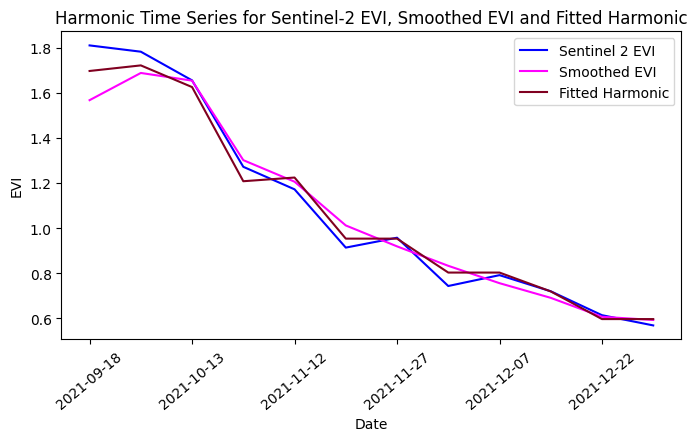

In [ ]:
# plot the two line on the same axes, us an instance for for the matplotlin.axes

ax = harmonic_UNSMOOTH_df.plot(x='date', y=['EVI','fitted'], kind='line', figsize=(8,4), rot=40, color=['#0000FF','#FF00FF'])
ax = harmonic_SMOOTH_df.plot(x='date', y='smoothed_evi', kind='line', figsize=(8,4), rot=40, color='#800020',ax=ax)

# setting labels for the axes
ax.set_xlabel('Date')
ax.set_ylabel('EVI')

# legend
ax.legend(['Sentinel 2 EVI', 'Smoothed EVI', 'Fitted Harmonic'], loc='upper right')

# display plot and title
plt.title('Harmonic Time Series for Sentinel-2 EVI, Smoothed EVI and Fitted Harmonic')
plt.show()
None

### Display images
- Display 10th images By index (9)
- display median sentinel 2 evi and smoothed median sentinel 2 evi

In [ ]:
# visualization parameters false color, evi and seasonality
false_params ={'bands': ['B8', 'B4', 'B3'], 'min': 0, 'max': 3000}
evi_params = {"bands": ['EVI'], "min": -0.5, "max": 1}

map = geemap.Map()
#map.setCenter(-0.2, 9.2, 9.5)
map.centerObject(myaoi, 11)

display_image(s2_masked, 9, false_params, '10th Sentinel 2 image', map)
map.addLayer(s2_EVI_median.select('EVI'), evi_params, 'Sentinel-2 Median EVI')
map.addLayer(seasonality, {}, 'Seasonality')
map.addLayer(myaoi,{}, 'My Area of interest')
map

Map(center=[9.407786028104447, -0.26535540771279714], controls=(WidgetControl(options=['position', 'transparen…